Michelle Hu  
---
University of Washington  
AMATH 563  
Homework 3  
Due: May 27, 2020  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import dask.array as da
import dask
import xarray as xr
import seaborn as sns

# import pickle
# import seaborn as sns

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
wd="/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw3"
data_dir=wd+"/data/"
model_dir=wd+"/models/"

cropped_dir=data_dir + "yale_cropped/"
uncropped_dir=data_dir + "yale_uncropped/"

### Functions

In [4]:
import glob
def fn_list(thisDir, fn_pattern):
    '''
    Function that returns a sorted list of filenames 
    based on a regex pattern in specified directory
    '''
    fns=[]
    for f in glob.glob(thisDir + "/" + fn_pattern): fns.append(f)
    fns.sort()
    return fns

In [5]:
# def densify(t, y, dt):
#     from scipy.interpolate import interp1d
#     f = interp1d(t, y, kind='cubic')
#     tnew = np.arange(t[0], t[-1], dt)
#     ynew = f(tnew)
#     return(tnew, ynew)

# def DMD(X, Xprime, r, dt):
#     '''Dynamic Mode Decomposition Function from book'''
#     U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
#     Ur = U[:,:r]
#     Sigmar = np.diag(Sigma[:r])
#     VTr = VT[:r,:]
#     Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
#     Lambda, W = np.linalg.eig(Atilde) # Step 3
#     Lambda = np.diag(Lambda)
    
#     Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
#     alpha1 = Sigmar @ VTr[:,0]
#     b = np.linalg.solve(W @ Lambda,alpha1)
#     Omega = np.log(np.diag(Lambda))/dt
#     return Phi, Omega, b, Lambda

# def forecast(Phi, Omega, t, b, r, dt):
#     u_modes = np.zeros((r, t))
#     time_vector = dt*np.arange(-1, t-1)
#     for i in np.arange(0, t):
#         u_modes[:, i]=b * np.exp(Omega * time_vector[i])
#     Xdmd = Phi @ u_modes
#     print(t, u_modes.shape, time_vector.shape, Xdmd.shape)
#     return(Xdmd)

#### Figure formatting

In [6]:
y_position=0.92
fontsize=16
weight="bold"

### Load data

In [7]:
cropped_fns = fn_list(data_dir+"yale_cropped/yale*", "*")
uncropped_fns = fn_list(data_dir+"yale_uncropped", "*")

# Start with cropped images 

#### With delayed 

In [8]:
%%time
xr_rio = dask.delayed(xr.open_rasterio, pure=True)

# Delayed
lazy=[xr_rio(fn) for fn in cropped_fns] 

# Get template
f=lazy[0].compute()

# Create dask array for image cube
arrays=[da.from_delayed(x, 
                      shape=f.shape, 
                      dtype=f.dtype) 
      for x in lazy]
stack = da.concatenate(arrays, axis=0)

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


CPU times: user 338 ms, sys: 11.8 ms, total: 350 ms
Wall time: 350 ms


In [9]:
stack

dask.array<concatenate, shape=(2432, 192, 168), dtype=uint8, chunksize=(1, 192, 168)>

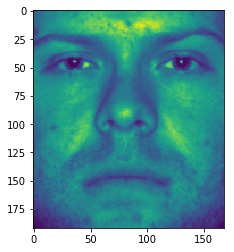

In [10]:
plt.imshow(stack[0])

## Question 1. Do an SVD analysis of the images

#### Reshape stack with images as column vectors (1D) and each image as a new column

In [13]:
%%time
# Create dask array for SVD analysis
arrays=[da.from_delayed(x, 
                      shape=f.shape, 
                      dtype=f.dtype) 
      for x in lazy]

rav_stack=[np.array(x).ravel() for x in arrays]
rav_stack = da.stack(rav_stack, axis=1)

CPU times: user 14.9 s, sys: 1.17 s, total: 16 s
Wall time: 16.8 s


In [20]:
%%time
rav_stack = np.array(rav_stack)

CPU times: user 916 ms, sys: 79.1 ms, total: 995 ms
Wall time: 910 ms


#### Direct computation

In [24]:
%%time
u, s, v = np.linalg.svd(rav_stack)

CPU times: user 1h 17min 48s, sys: 2min 10s, total: 1h 19min 59s
Wall time: 4min 22s


Modes > 0.00%:  6


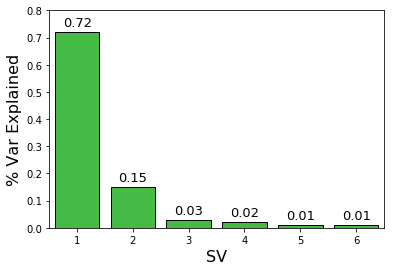

In [83]:
var_explained = np.round(s**2/np.sum(s**2), decimals=2)
print("Modes > 0.00%: ", 
      len(var_explained[var_explained>0]))

subset=len(var_explained[var_explained>0])
fig, ax = plt.subplots(figsize=(6, 4))
svd_bars = sns.barplot(x=list(range(1,len(var_explained[:subset])+1)),
                       y=var_explained[:subset], color="limegreen", ec='k', ax=ax)
ax.set_xlabel('SV', fontsize=16)
ax.set_ylabel('% Var Explained', fontsize=16)
ax.set_ylim(0, 0.8)

# Label the bars
for p in svd_bars.patches:
    width = p.get_width()
    ax.text(p.get_x() + p.get_width()/2., 
            p.get_height()+0.01, 
            np.round(p.get_height(), 2), 
            fontsize=13, color='k', ha='center', va='bottom')

In [84]:
%%time
import scipy 
u, s, v = scipy.linalg.svd(rav_stack)

CPU times: user 41min 57s, sys: 1min 40s, total: 43min 37s
Wall time: 2min 14s


Modes > 0.00%:  6


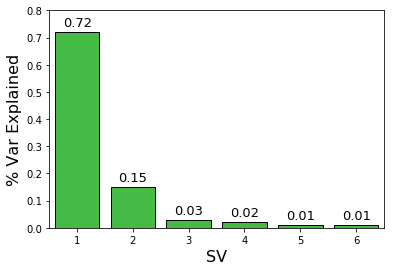

In [85]:
var_explained = np.round(s**2/np.sum(s**2), decimals=2)
print("Modes > 0.00%: ", 
      len(var_explained[var_explained>0]))

subset=len(var_explained[var_explained>0])
fig, ax = plt.subplots(figsize=(6, 4))
svd_bars = sns.barplot(x=list(range(1,len(var_explained[:subset])+1)),
                       y=var_explained[:subset], color="limegreen", ec='k', ax=ax)
ax.set_xlabel('SV', fontsize=16)
ax.set_ylabel('% Var Explained', fontsize=16)
ax.set_ylim(0, 0.8)

# Label the bars
for p in svd_bars.patches:
    width = p.get_width()
    ax.text(p.get_x() + p.get_width()/2., 
            p.get_height()+0.01, 
            np.round(p.get_height(), 2), 
            fontsize=13, color='k', ha='center', va='bottom')

#### Truncated computation

In [94]:
%%time
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
svd.fit(rav_stack)

CPU times: user 32.9 s, sys: 16 s, total: 48.9 s
Wall time: 4.8 s


In [95]:
svd.explained_variance_ratio_

array([0.11149673, 0.46498221, 0.07935187, 0.05926816, 0.02009348,
       0.01910296, 0.01431927, 0.01250264, 0.00994269, 0.00978692])

In [96]:
svd.explained_variance_ratio_.sum()

0.8008469305982837

In [97]:
svd.singular_values_

array([700713.66880122, 318294.97785939, 132243.9176869 , 113876.21602423,
        66167.63611551,  64511.96226738,  55861.38118987,  52310.40812852,
        46585.50069695,  46195.85042184])

In [98]:
svd.n_components

10

In [102]:
svd.components_.shape

(10, 2432)

In [115]:
svd.explained_variance_

array([ 753055.15234354, 3140515.96609096,  535947.00287113,
        400300.49658712,  135712.48563372,  129022.4991268 ,
         96713.17524288,   84443.53205628,   67153.50060865,
         66101.39049151])

In [116]:
svd.explained_variance_ratio_

array([0.11149673, 0.46498221, 0.07935187, 0.05926816, 0.02009348,
       0.01910296, 0.01431927, 0.01250264, 0.00994269, 0.00978692])

In [111]:
np.round(svd.singular_values_**2/np.sum(svd.singular_values_**2), 2)

array([0.77, 0.16, 0.03, 0.02, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  ])

Modes > 0.00%:  6


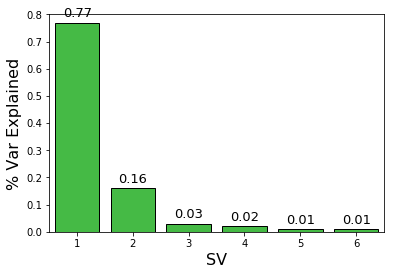

In [117]:
var_explained = np.round(svd.singular_values_**2/np.sum(svd.singular_values_**2), 2)
print("Modes > 0.00%: ", 
      len(var_explained[var_explained>0]))

subset=len(var_explained[var_explained>0])
fig, ax = plt.subplots(figsize=(6, 4))
svd_bars = sns.barplot(x=list(range(1,len(var_explained[:subset])+1)),
                       y=var_explained[:subset], color="limegreen", ec='k', ax=ax)
ax.set_xlabel('SV', fontsize=16)
ax.set_ylabel('% Var Explained', fontsize=16)
ax.set_ylim(0, 0.8)

# Label the bars
for p in svd_bars.patches:
    width = p.get_width()
    ax.text(p.get_x() + p.get_width()/2., 
            p.get_height()+0.01, 
            np.round(p.get_height(), 2), 
            fontsize=13, color='k', ha='center', va='bottom')

In [106]:
u.shape

(32256, 32256)

In [107]:
s.shape

(2432,)

In [108]:
v.shape

(2432, 2432)

In [ ]:
U = 
Sigma = 
V = 

---